Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [14]:
import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#####Insight: The following data mounting is done using Google Collab data impoted via Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
root_path = '/content/drive/MyDrive/CNN/CNN_assignment'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.



In [17]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Create a dataset

Define some parameters for the loader:

In [19]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [20]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [21]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int', color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [22]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

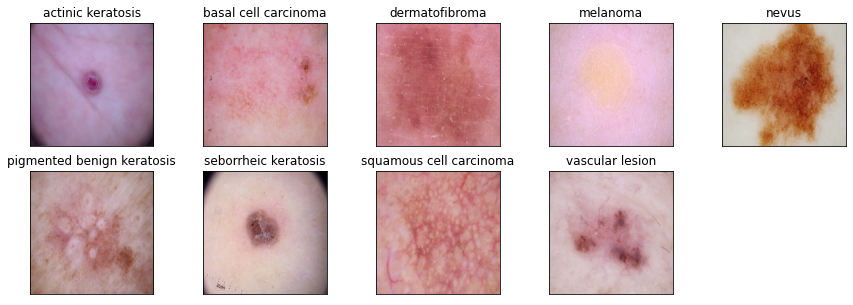

In [23]:
import matplotlib.pyplot as plt

fig= plt.figure(figsize=[15,5])
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        plt.subplot(2,5,1+i, xticks =[], yticks =[])
        plt. imshow(images[i].numpy().astype('int64'))
        plt.title(class_names[i])
        
        
plt.show()        
        

In [91]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

#### **Create the model**

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [24]:
### Your code goes here

num_classes =9

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.6),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(num_classes)     
])                   


#### Compile the model
Choose an appropirate optimiser and loss function for model training




In [168]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [169]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

####Train the model

In [170]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 40s 227ms/step - loss: 3.6568 - accuracy: 0.1901 - val_loss: 1.7430 - val_accuracy: 0.3504
Epoch 2/20
169/169 [==============================] - 39s 225ms/step - loss: 1.6419 - accuracy: 0.3887 - val_loss: 1.4405 - val_accuracy: 0.4699
Epoch 3/20
169/169 [==============================] - 39s 225ms/step - loss: 1.4731 - accuracy: 0.4449 - val_loss: 1.4100 - val_accuracy: 0.4826
Epoch 4/20
169/169 [==============================] - 39s 225ms/step - loss: 1.4046 - accuracy: 0.4717 - val_loss: 1.3511 - val_accuracy: 0.4840
Epoch 5/20
169/169 [==============================] - 39s 226ms/step - loss: 1.3414 - accuracy: 0.4958 - val_loss: 1.2719 - val_accuracy: 0.5286
Epoch 6/20
169/169 [==============================] - 39s 225ms/step - loss: 1.2363 - accuracy: 0.5347 - val_loss: 1.3548 - val_accuracy: 0.5115
Epoch 7/20
169/169 [==============================] - 39s 226ms/step - loss: 1.2147 - accuracy: 0.5375 - val_loss: 1.2115 - val_ac

### Visualizing training results


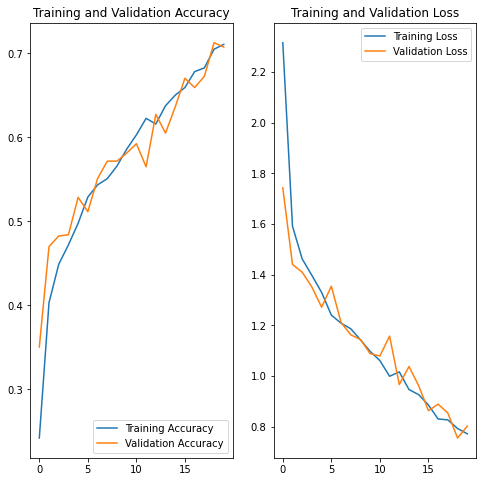

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation: The results are seen to be good with 70% Training and Validation accuracy. However it can further be improved with further training of modules with augmentation.

In [161]:
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

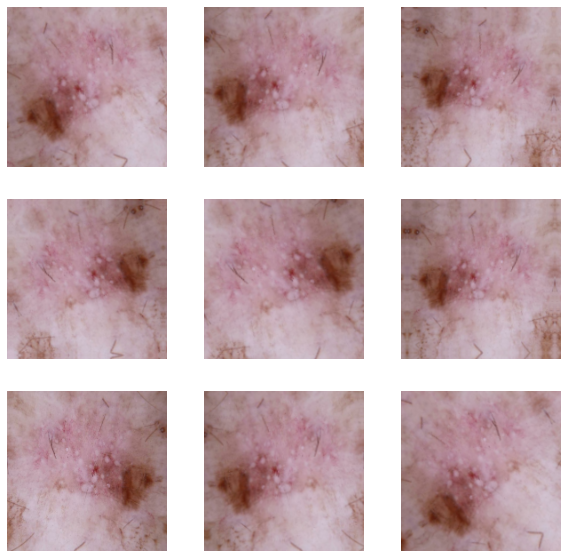

In [162]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Creating the model, compiling and training the model

In [163]:
## We are using a  Dropout layer as there is an evidence of overfitting in the above findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


####Compiling the model

In [177]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [178]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

####Training the model

In [179]:
## Training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 40s 227ms/step - loss: 0.7454 - accuracy: 0.7175 - val_loss: 0.7992 - val_accuracy: 0.7038
Epoch 2/20
169/169 [==============================] - 39s 226ms/step - loss: 0.7028 - accuracy: 0.7274 - val_loss: 0.8141 - val_accuracy: 0.6964
Epoch 3/20
169/169 [==============================] - 39s 225ms/step - loss: 0.6861 - accuracy: 0.7424 - val_loss: 0.7529 - val_accuracy: 0.7305
Epoch 4/20
169/169 [==============================] - 40s 228ms/step - loss: 0.6577 - accuracy: 0.7596 - val_loss: 0.7653 - val_accuracy: 0.7164
Epoch 5/20
169/169 [==============================] - 39s 226ms/step - loss: 0.6327 - accuracy: 0.7595 - val_loss: 0.7593 - val_accuracy: 0.7320
Epoch 6/20
169/169 [==============================] - 39s 224ms/step - loss: 0.6127 - accuracy: 0.7730 - val_loss: 0.6667 - val_accuracy: 0.7654
Epoch 7/20
169/169 [==============================] - 39s 224ms/step - loss: 0.5772 - accuracy: 0.7743 - val_loss: 0.6415 - val_ac

### Visualizing the results


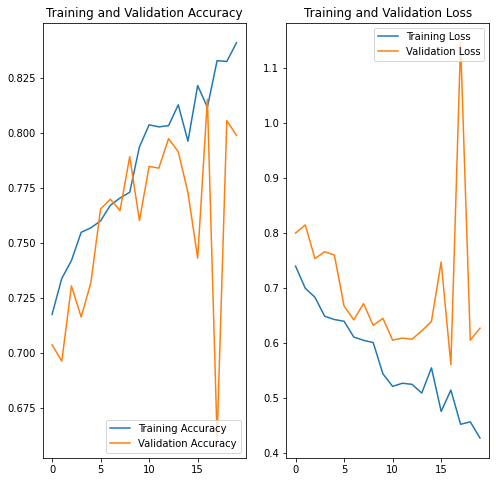

In [182]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation: The results are seen to be good with 84% Training Accuracy and 80% Validation accuracy. However there was drop observed in Validation Accuracy and high in Validation Loss which could further be improved in higher number of epochs as Training and Validation accuracy is quite stationary to each other.

In [183]:


data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis")
print("Actinic keratosis")
paths1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(paths1))
ak

Actinic keratosis


614

In [184]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma")
print("Basal cell carcinoma")
paths2 = Path(data_dir_train).glob('**/*.jpg')
bcc=len(list(paths2))
bcc

Basal cell carcinoma


876

In [185]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma")
print("Dermatofibroma")
paths3 = Path(data_dir_train).glob('**/*.jpg')
d=len(list(paths3))
d

Dermatofibroma


595

In [186]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma")

print("Melanoma")
paths4 = Path(data_dir_train).glob('**/*.jpg')
m=len(list(paths4))
m

Melanoma


938

In [187]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus")
print("Nevus")
paths5 = Path(data_dir_train).glob('**/*.jpg')
n=len(list(paths5))
n

Nevus


857

In [188]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis")
print("Pigmented benign keratosis")
paths6 = Path(data_dir_train).glob('**/*.jpg')
pbk=len(list(paths6))
pbk

Pigmented benign keratosis


962

In [189]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis")
print("Seborrheic keratosis")
paths7 = Path(data_dir_train).glob('**/*.jpg')
sk=len(list(paths7))
sk

Seborrheic keratosis


577

In [190]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma")
print("Squamous cell carcinoma")
paths8 = Path(data_dir_train).glob('**/*.jpg')
scc=len(list(paths8))
scc

Squamous cell carcinoma


681

In [191]:

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion")
print("Vascular lesion")
paths9 = Path(data_dir_train).glob('**/*.jpg')
vl=len(list(paths9))
vl

Vascular lesion


639

Observation:

1. Seborrheic keratosis class has the least number of the given samples.
2. Pigmented benign keratosis class dominates the data in terms of proportionate number of samples

In [61]:
Total=ak+bcc+d+m+n+pbk+sk+scc+vl
Total

2239

Observation: Total of all classes sum up the same total number of training data, 2239 images

#### Data Augumentation

In [192]:
!pip install Augmentor

In [193]:
path_to_training_dataset=os.getcwd()
path_to_training_dataset = "/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
print(path_to_training_dataset)

/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [194]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B9A879290>: 100%|██████████| 500/500 [00:18<00:00, 27.16 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B2FEBA590>: 100%|██████████| 500/500 [00:17<00:00, 27.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BA5728390>: 100%|██████████| 500/500 [00:19<00:00, 26.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1B33525850>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BA56EAE90>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B331DCA50>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1BA5ED7F90>: 100%|██████████| 500/500 [00:40<00:00, 12.45 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1BA5EE5310>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B2FEC62D0>: 100%|██████████| 500/500 [00:18<00:00, 27.44 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1BA5EEA2D0>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [195]:
data_dir_train = pathlib.Path(path_to_training_dataset)

In [196]:
print(data_dir_train)

/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [197]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [198]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027771.jpg_4cab0137-3caf-46ee-bbd1-7f72decfaf15.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024602.jpg_3c412189-c165-447d-a265-b795664e77a6.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026803.jpg_8de9a214-2da1-4acf-8372-47957e429bab.jpg',
 '/content/gdrive/MyDrive/CNN/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025083.jpg_9788d5c2-e460-40d4-ab2f-ba4e172ab84d.jpg',
 '/content/gdrive/MyDrive/CN

In [199]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [200]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [201]:
batch_size = 32
img_height = 180
img_width = 180

In [202]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [203]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [204]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.12450981 0.9779411


In [206]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compiling the model

In [207]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [208]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

Train the  model

In [209]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 60s 210ms/step - loss: 1.9595 - accuracy: 0.2463 - val_loss: 1.3233 - val_accuracy: 0.4967
Epoch 2/30
281/281 [==============================] - 59s 207ms/step - loss: 1.2685 - accuracy: 0.5301 - val_loss: 1.0749 - val_accuracy: 0.6039
Epoch 3/30
281/281 [==============================] - 59s 206ms/step - loss: 0.9715 - accuracy: 0.6531 - val_loss: 1.0559 - val_accuracy: 0.6231
Epoch 4/30
281/281 [==============================] - 59s 206ms/step - loss: 0.7971 - accuracy: 0.7078 - val_loss: 0.6968 - val_accuracy: 0.7437
Epoch 5/30
281/281 [==============================] - 58s 204ms/step - loss: 0.5576 - accuracy: 0.7992 - val_loss: 0.5954 - val_accuracy: 0.7908
Epoch 6/30
281/281 [==============================] - 59s 206ms/step - loss: 0.4039 - accuracy: 0.8599 - val_loss: 0.5560 - val_accuracy: 0.7988
Epoch 7/30
281/281 [==============================] - 58s 203ms/step - loss: 0.3311 - accuracy: 0.8827 - val_loss: 0.5919 - val_ac

Visualize the model

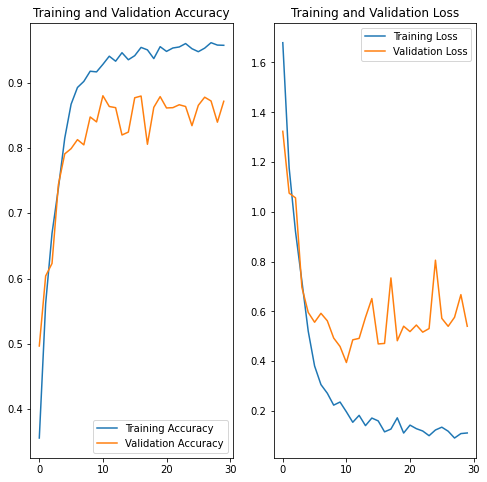

In [210]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation: The results are seen to be very good with 95% Training Accuracy and 87% Validation accuracy which has been greatly imporved considering the previous visualization graphs hence we can say it is advisable for real time use.